In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from statsmodels.stats.anova import AnovaRM
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.signal import find_peaks, peak_prominences, peak_widths
from scipy.integrate import trapezoid
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import iqr
from sklearn.preprocessing import PolynomialFeatures
import math
from sklearn.tree import DecisionTreeRegressor

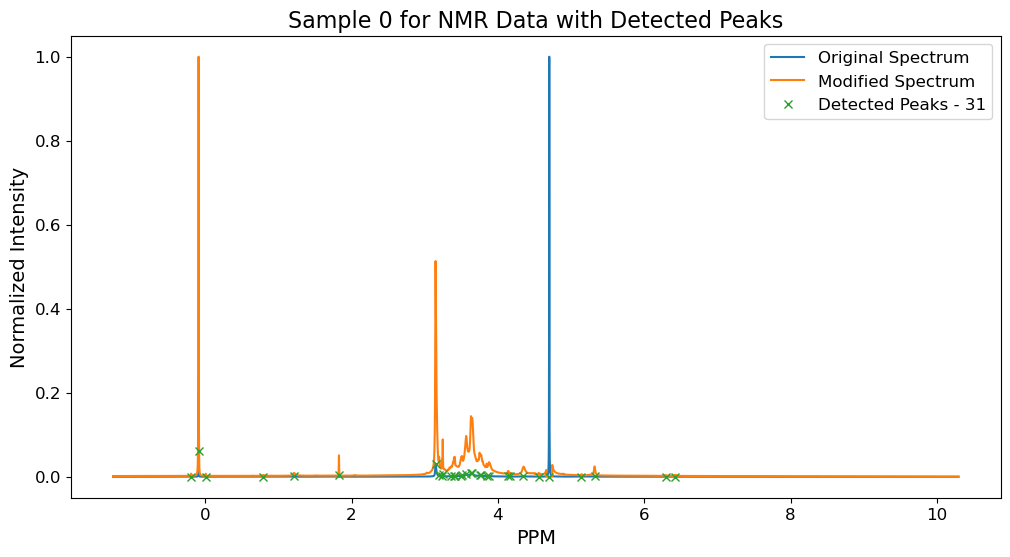

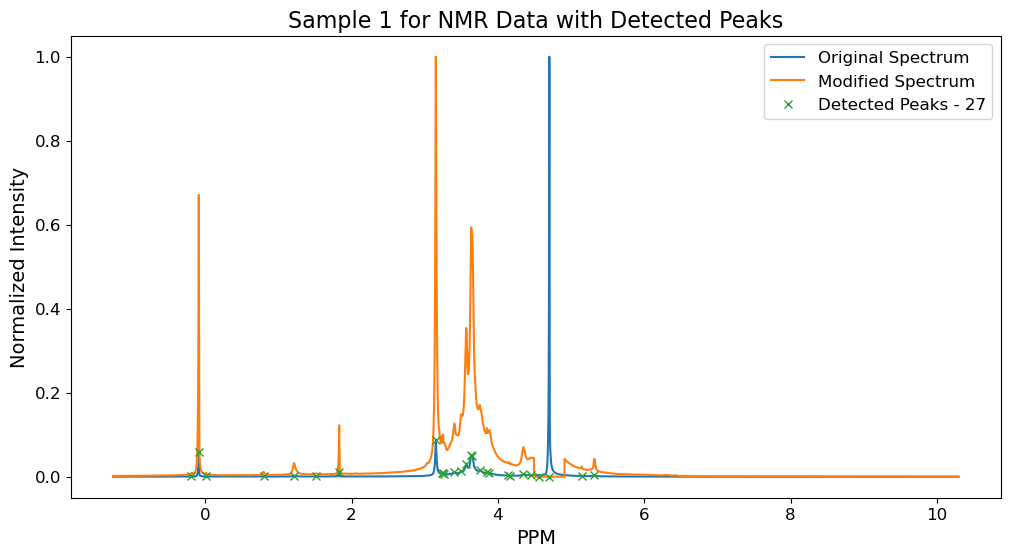

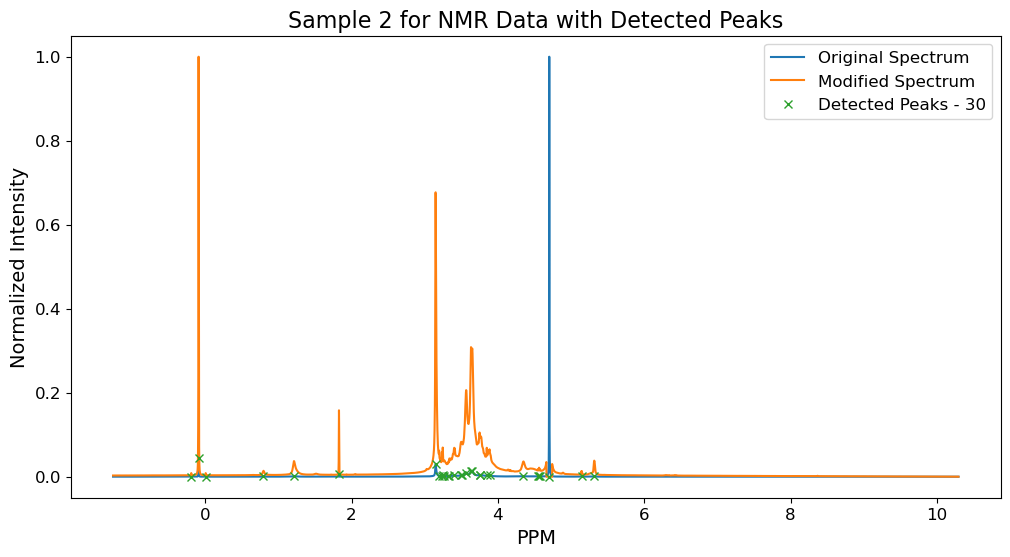

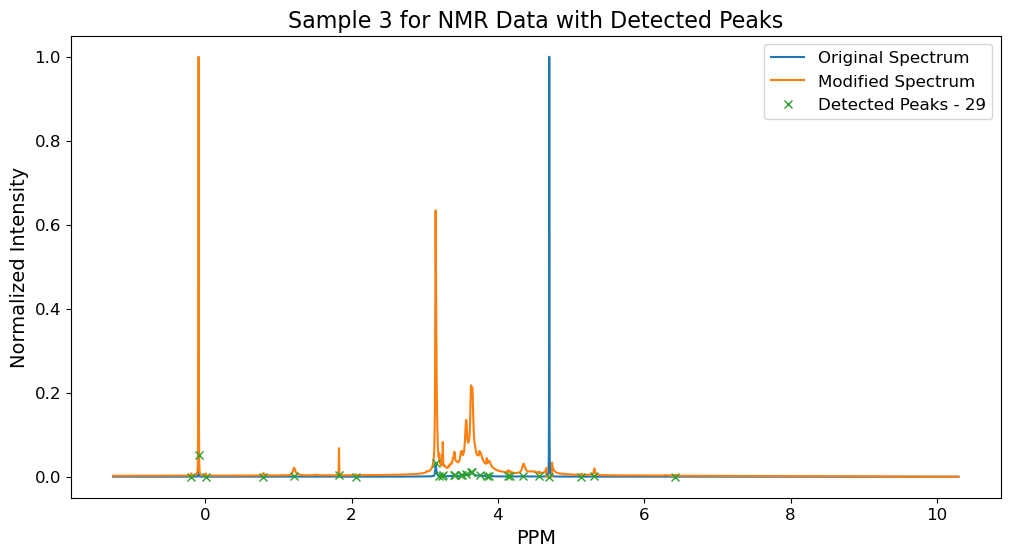

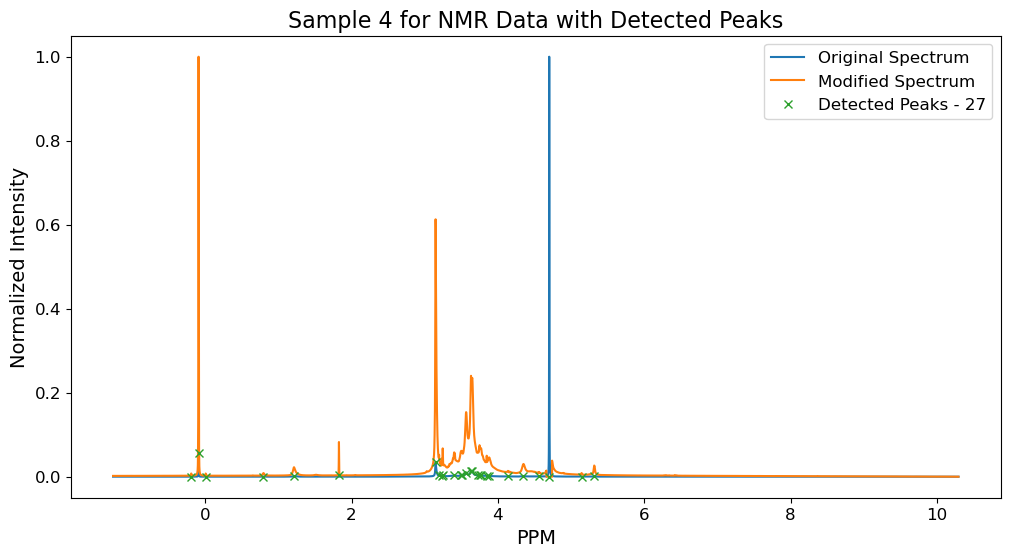

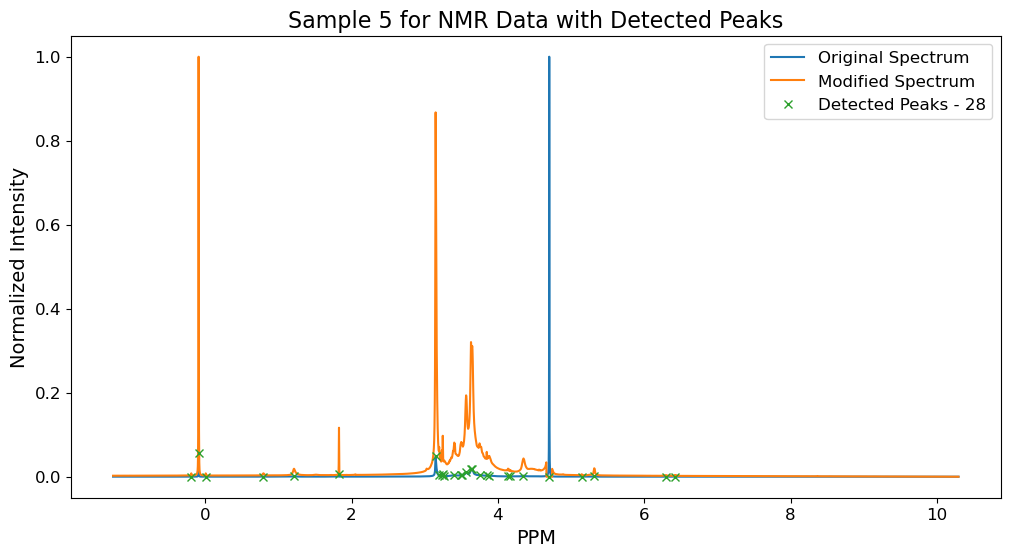

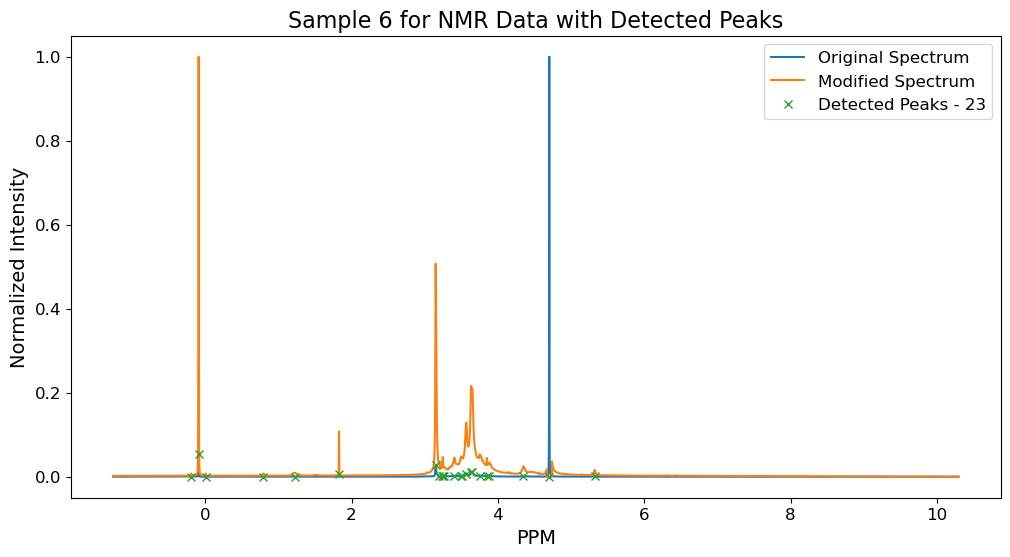

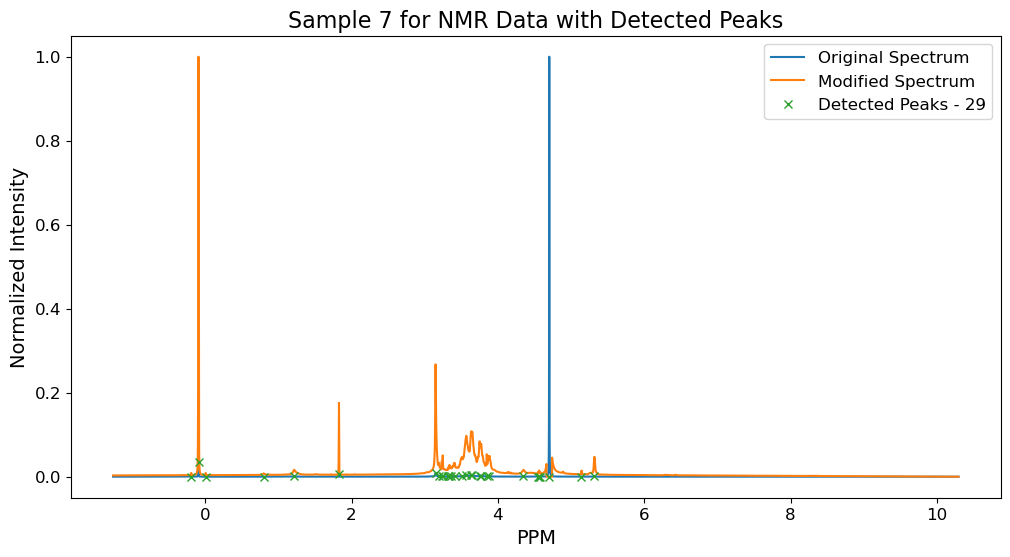

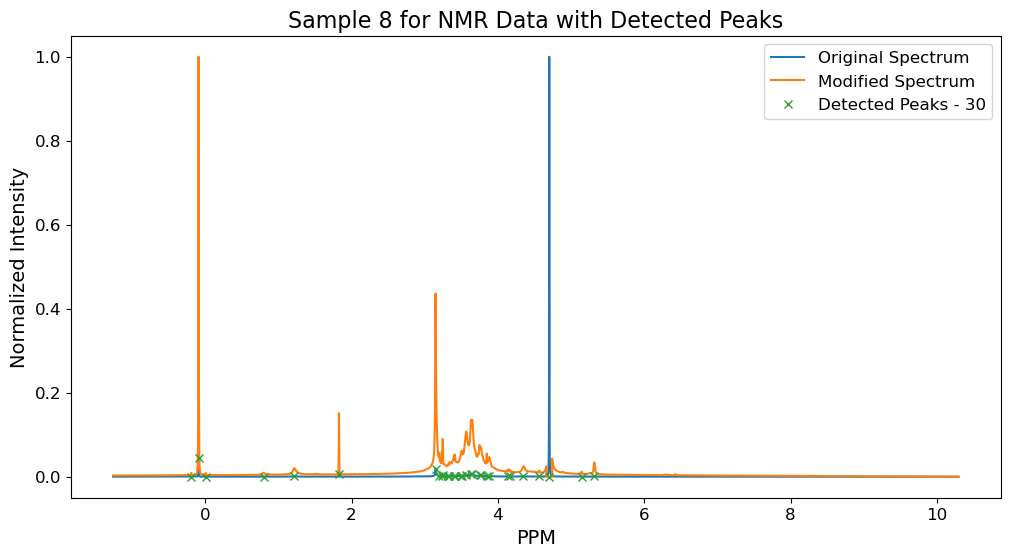

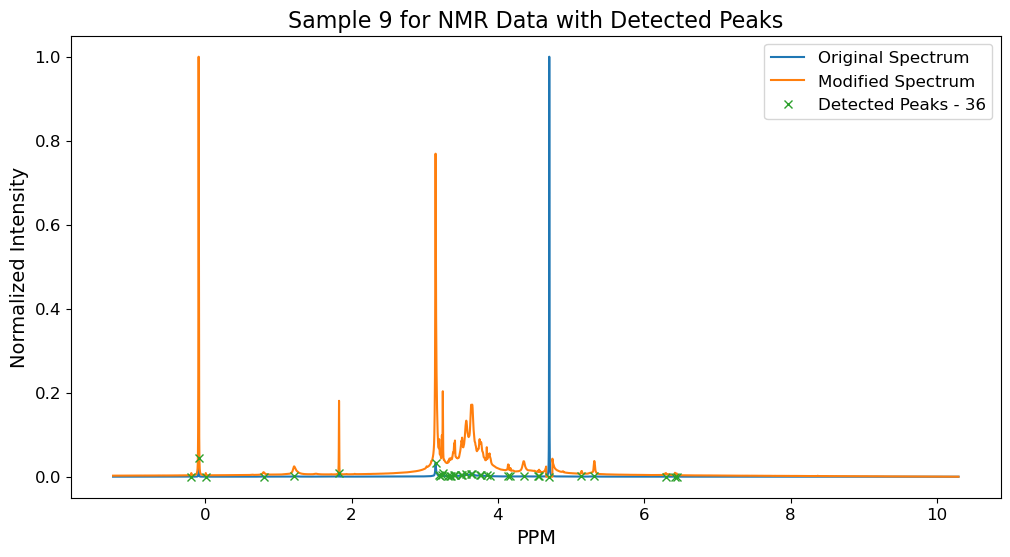

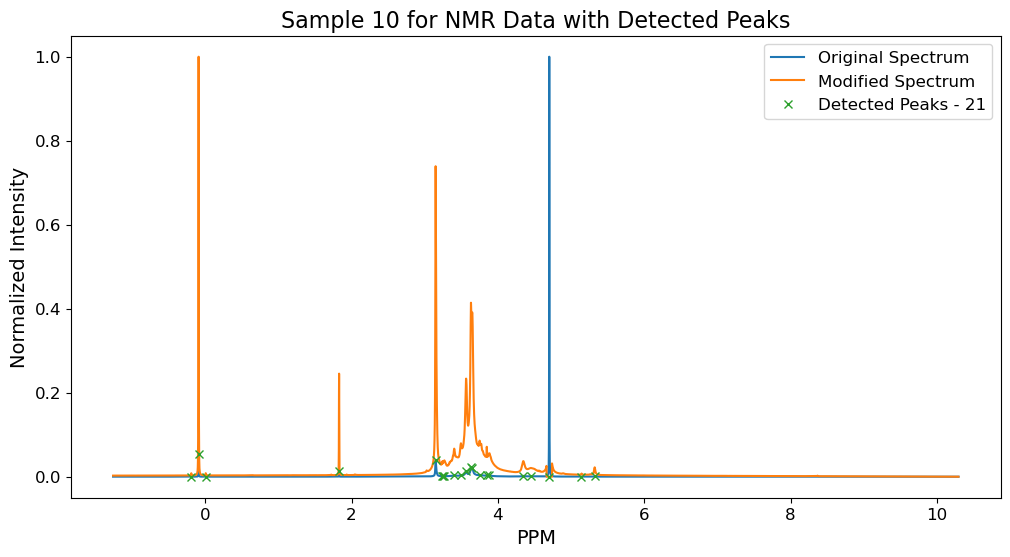

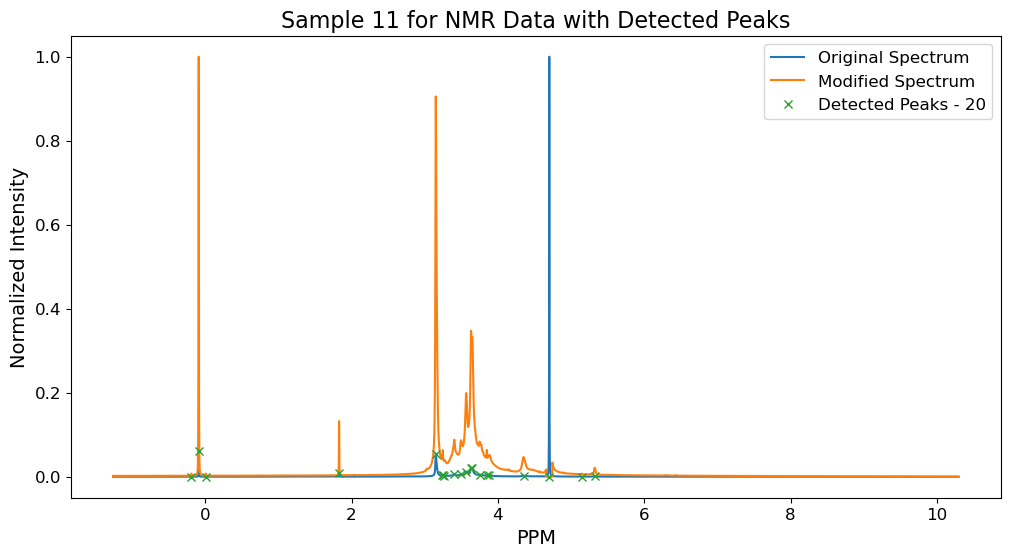

/var/folders/r_/wk12dxb50s3_zfk_x4b2drnm0000gn/T/ipykernel_12925/580510641.py:74: PeakPropertyWarning: some peaks have a prominence of 0
  widths = peak_widths(spectrum, peaks_with_no_water, rel_height=0.995)
/var/folders/r_/wk12dxb50s3_zfk_x4b2drnm0000gn/T/ipykernel_12925/580510641.py:74: PeakPropertyWarning: some peaks have a width of 0
  widths = peak_widths(spectrum, peaks_with_no_water, rel_height=0.995)


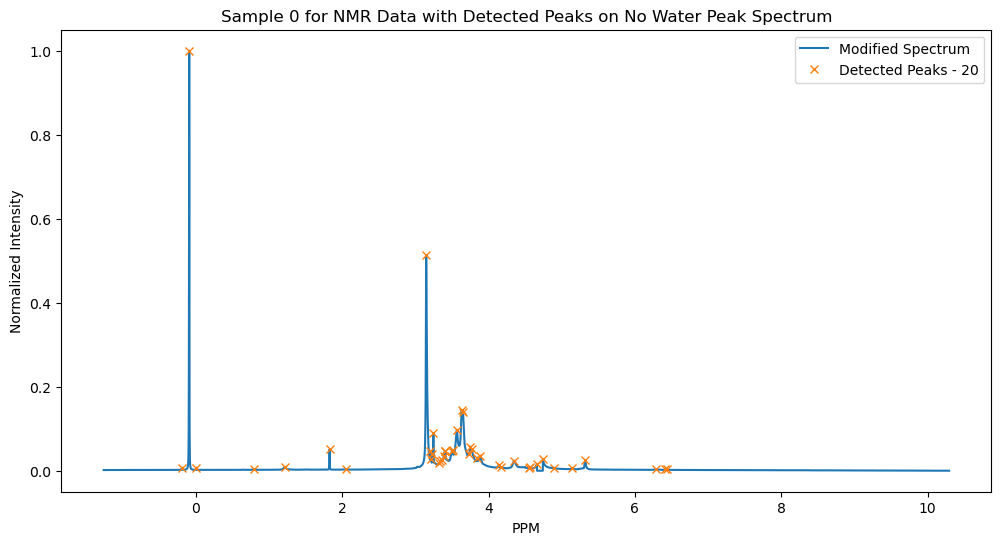

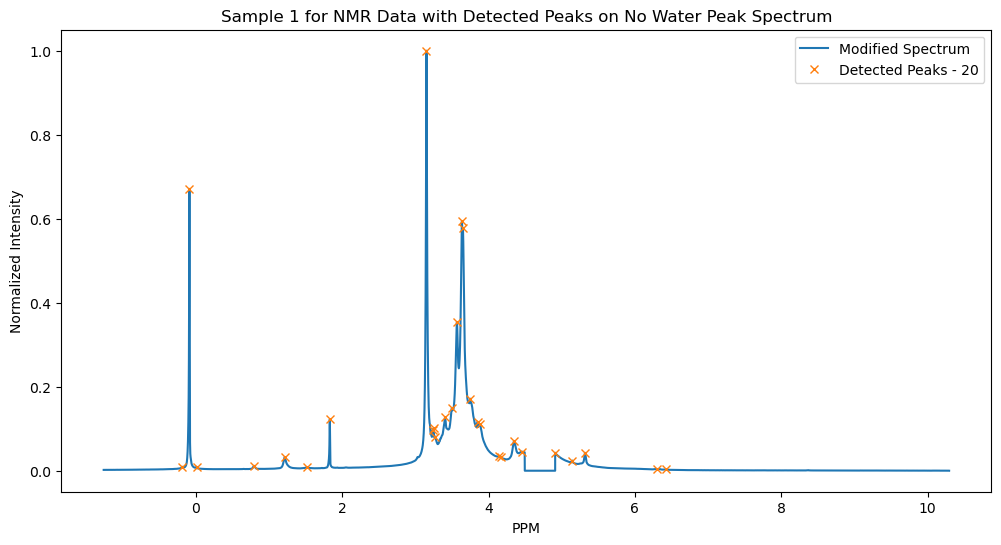

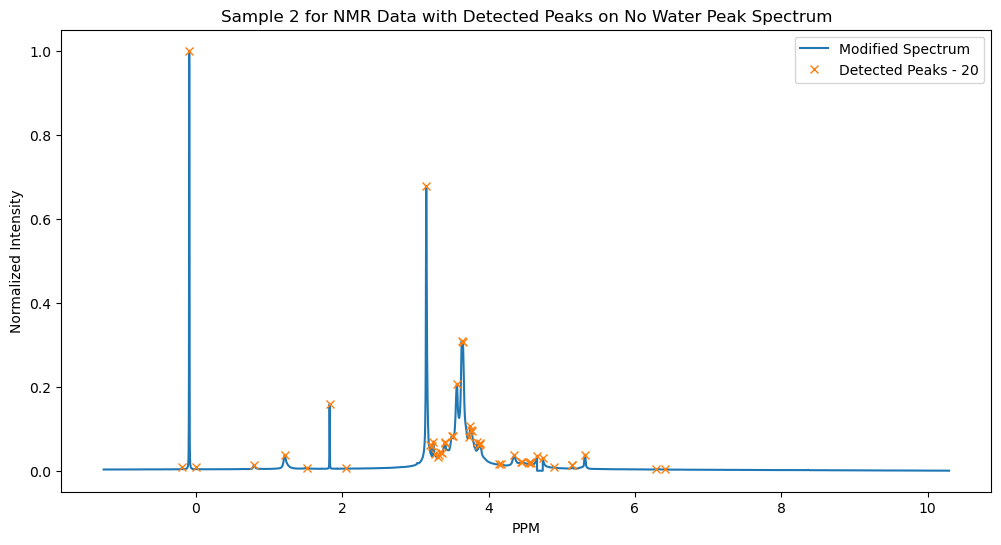

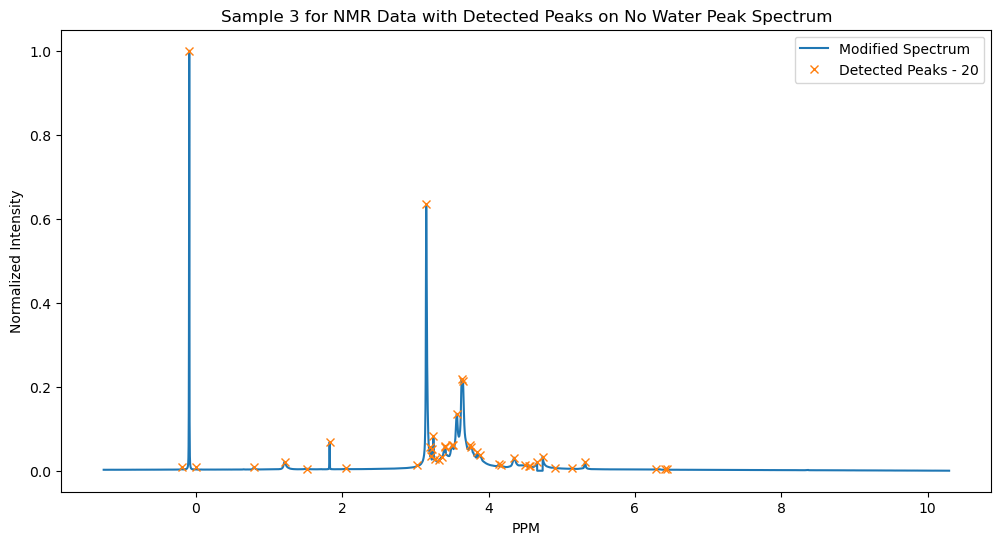

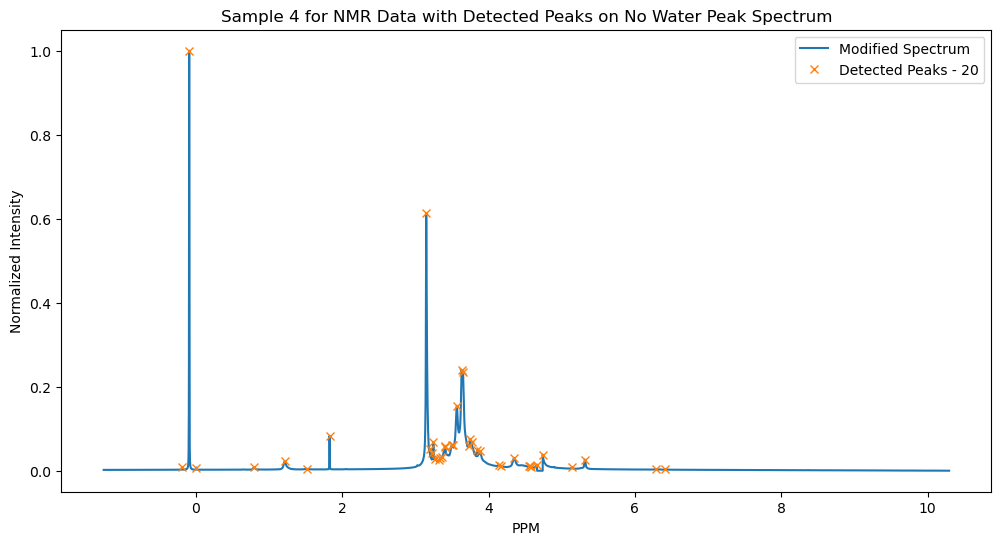

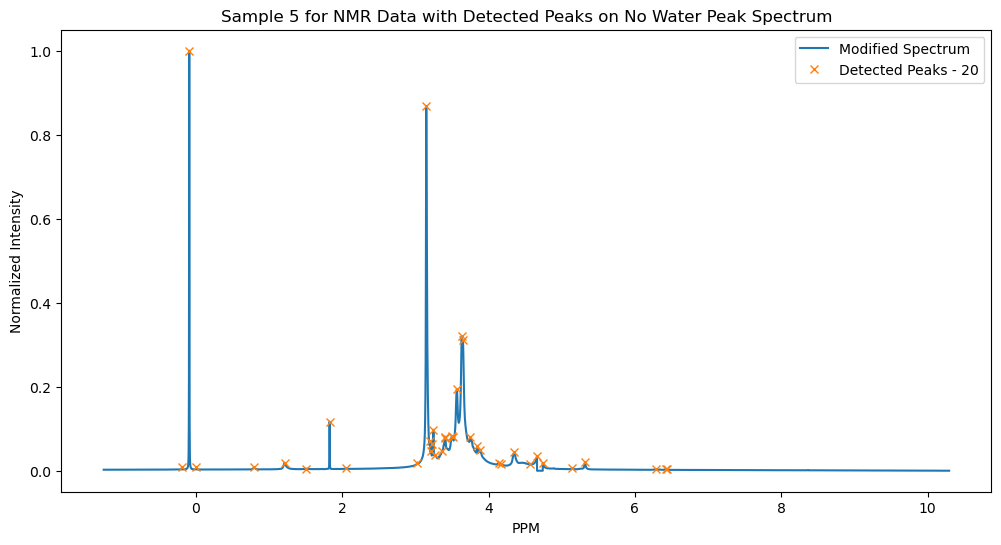

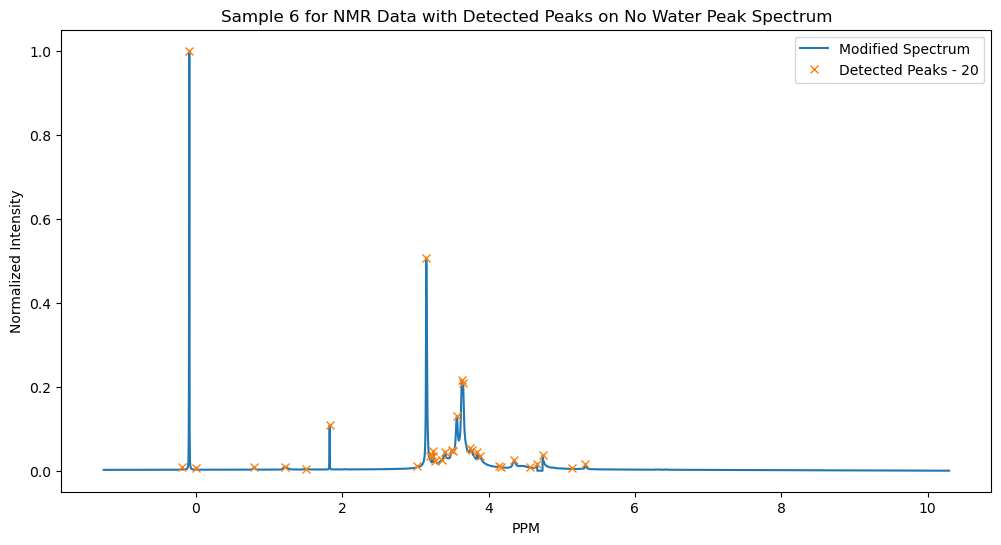

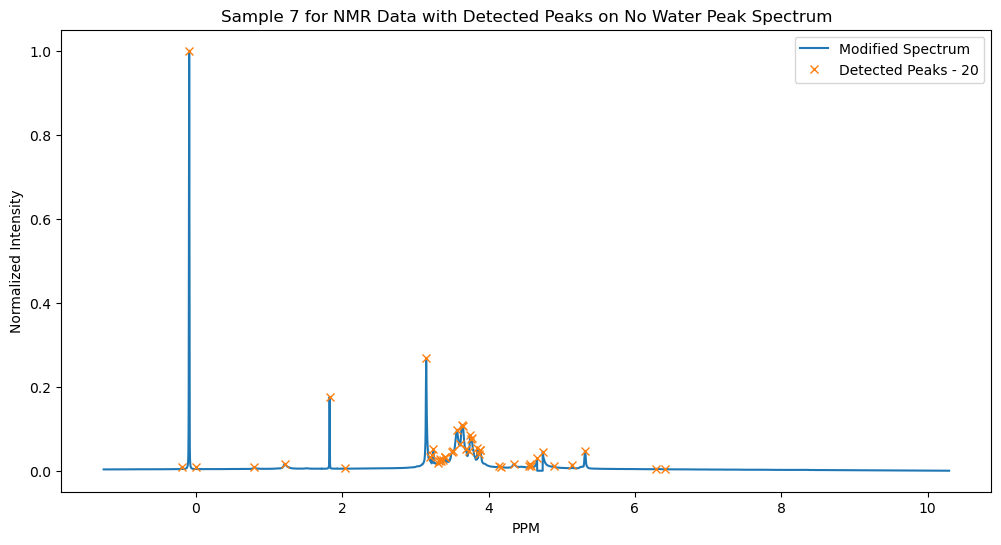

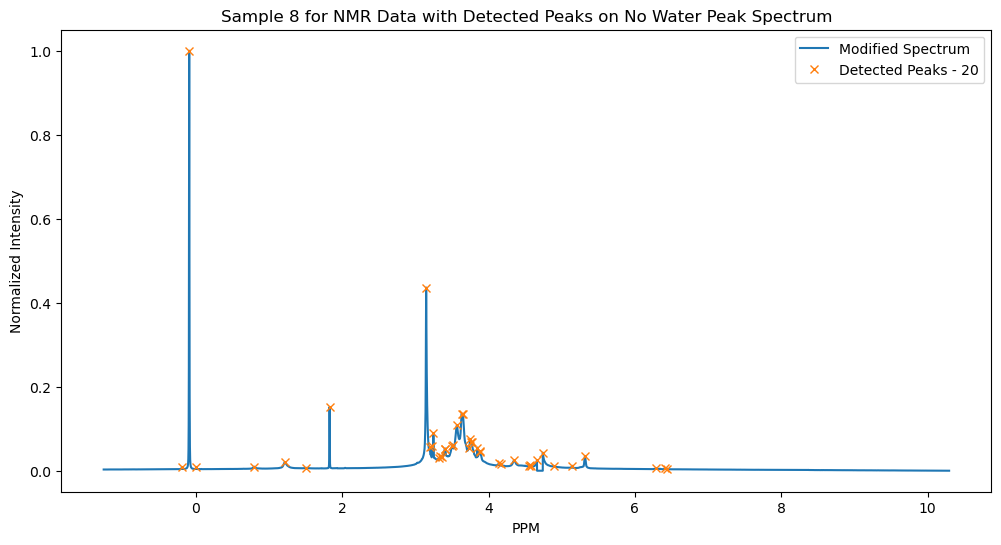

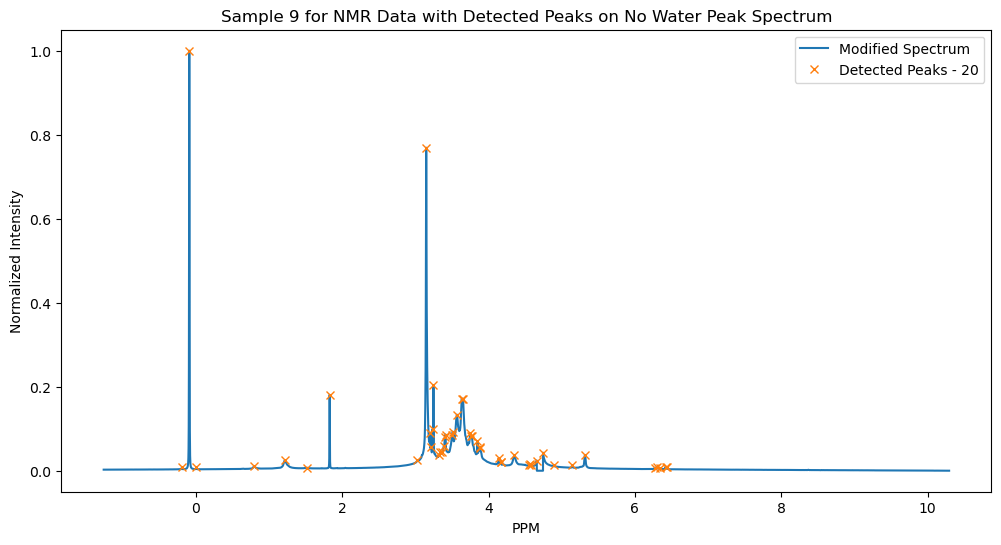

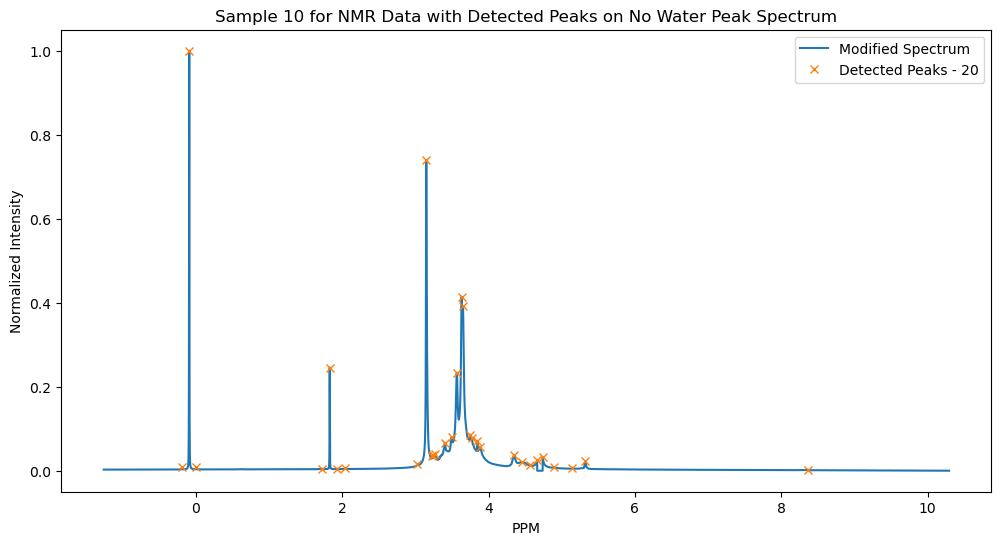

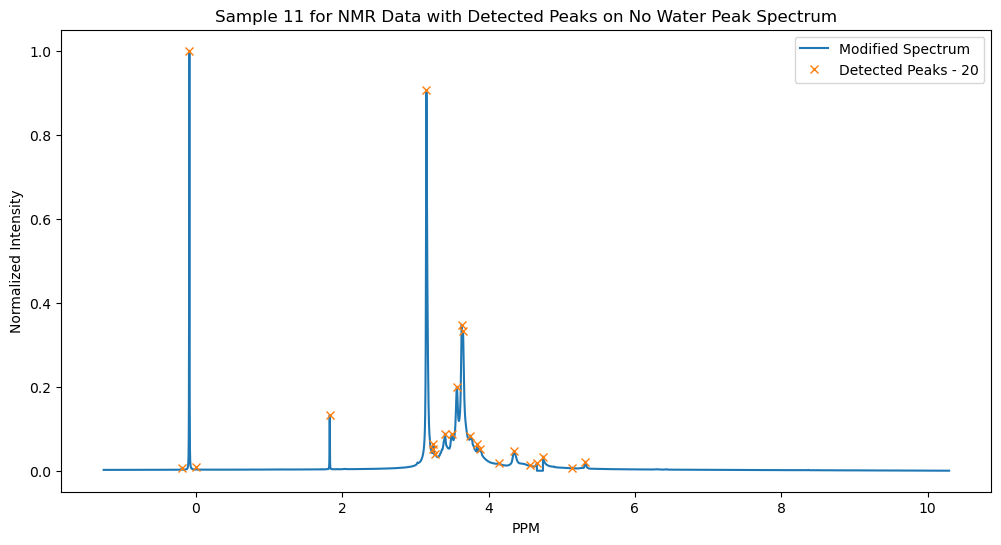

In [11]:
def load_and_normalize_data(filepath):
    nmr_df = pd.read_csv(filepath)
    index_labels = nmr_df.index
    nmr_intensity = nmr_df.filter(regex='Intensity_') # Extract columns that match 'Intensity_'
    nmr_ppm = nmr_df.filter(regex='PPM_')             # Extract columns that match 'PPM_'

    # Normalize intensities by subtracting the minimum and dividing by the range
    
    nmr_intensity_normalized = (nmr_intensity.subtract(nmr_intensity.min(axis=1), axis=0)
                                .div(nmr_intensity.max(axis=1) - nmr_intensity.min(axis=1), axis=0))
    return nmr_ppm, nmr_intensity_normalized, index_labels



filepath = "/Users/suhasmathey/Library/CloudStorage/OneDrive-UniversityofDelaware-o365/Spring_24/ELEG848 Soft Materials Inn/NMR_Data/NMR_Data.csv"
nmr_ppm, normalized_intensity, index_labels = load_and_normalize_data(filepath)




whole_spectra = []
# Now we can iterate over all samples (Indentify the Peak and Plotting the Peaks on Original Spectrum) - Logic

for sample_index in range(normalized_intensity.shape[0]):
    spectrum = normalized_intensity.iloc[sample_index, :].copy()
    org_spectrum = spectrum.copy()
    ppm_values = nmr_ppm.iloc[sample_index, :]
    peaks, _ = find_peaks(spectrum, prominence=0.0001)
    peak_count = len(peaks)
    widths = peak_widths(spectrum, peaks, rel_height=0.995)
    #print(f"Widths of the peaks for Sample {sample_index}:", widths)

    # Identify the water peak to minimize
    just_widths = widths[0]
    if len(peaks) > 0:  # Check if there are any peaks
        max_peak_index = peaks[np.argmax(spectrum.iloc[peaks])]
        max_peak_width = just_widths[np.argmax(spectrum.iloc[peaks])]
        # Set range around the water peak to minimum
        left_range = math.ceil(max_peak_index - max_peak_width)
        right_range = math.floor(max_peak_index + max_peak_width)
        spectrum[left_range:right_range] = min(spectrum)
    
    # Normalize the modified spectrum
    max_no_waterpeak_spectrum = (spectrum - min(spectrum)) / (max(spectrum) - min(spectrum))
    #peaks_with_no_waterpeak, _ = find_peaks(max_no_waterpeak_spectrum, prominence=0.001)
    whole_spectra.append(max_no_waterpeak_spectrum)
    whole_spectra_df = pd.DataFrame(whole_spectra)


    plt.figure(figsize=(12, 6))
    plt.plot(nmr_ppm.iloc[sample_index, :], org_spectrum, label='Original Spectrum')
    plt.plot(nmr_ppm.iloc[sample_index, :], max_no_waterpeak_spectrum, label='Modified Spectrum')
    plt.plot(nmr_ppm.iloc[sample_index, peaks], spectrum.iloc[peaks], "x", label=f'Detected Peaks - {peak_count}')
    plt.title(f'Sample {sample_index} for NMR Data with Detected Peaks', fontsize=16)
    plt.xlabel('PPM', fontsize=14)
    plt.ylabel('Normalized Intensity', fontsize=14)
    plt.xticks(fontsize=12)  
    plt.yticks(fontsize=12)  
    plt.legend(fontsize=12)
    plt.show()



peaks_info = []

for sample_index in range(whole_spectra_df.shape[0]):

    no_waterpeak_spectrum = whole_spectra_df.iloc[sample_index, :].copy()
    
    intensity = normalized_intensity.iloc[sample_index, :]
    ppm_values = nmr_ppm.iloc[sample_index, :]
    peaks_with_no_water, _ = find_peaks(no_waterpeak_spectrum, prominence=0.001)
    peak_count = len(peaks)
    widths = peak_widths(spectrum, peaks_with_no_water, rel_height=0.995)

    peaks_info.append(peaks_with_no_water)

    


    plt.figure(figsize=(12, 6))
    
    plt.plot(nmr_ppm.iloc[sample_index, :], no_waterpeak_spectrum, label='Modified Spectrum')
    plt.plot(nmr_ppm.iloc[sample_index, peaks_with_no_water], no_waterpeak_spectrum.iloc[peaks_with_no_water], "x", label=f'Detected Peaks - {peak_count}')
    plt.title(f'Sample {sample_index} for NMR Data with Detected Peaks on No Water Peak Spectrum')
    plt.xlabel('PPM')
    plt.ylabel('Normalized Intensity')
    plt.legend()
    plt.show()


#print(whole_spectra_df)
#print(binned_data_df)

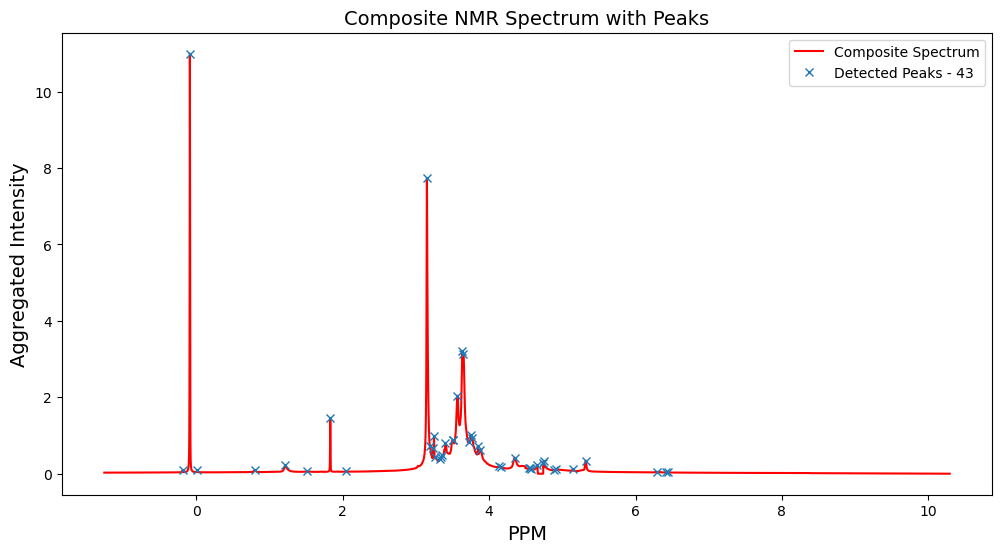

In [3]:
def aggregate_intensities(whole_spectra_df):

    return whole_spectra_df.sum(axis=0)

def bin_around_peaks(whole_spectra_df, ppm_values_df, widths):

    binned_data_list = []

    for i in range(whole_spectra_df.shape[0]):
        sample_intensities = whole_spectra_df.iloc[i, :].values
        ppm_values = ppm_values_df.iloc[i, :].values
        binned_sample_data = []

        for j, peak in enumerate(no_water_peaks):

            window_width = int(widths[0][j])
            window_start = max(0, peak - window_width)
            window_end = min(len(sample_intensities), peak + window_width + 1)
            bin_area = np.trapz(sample_intensities[window_start:window_end], ppm_values[window_start:window_end])
            binned_sample_data.append(bin_area)

        binned_data_list.append(binned_sample_data)

    return pd.DataFrame(binned_data_list, columns=[f'Bin_{i}' for i in range(len(no_water_peaks))])


composite_spectrum = aggregate_intensities(whole_spectra_df)


no_water_peaks, properties = find_peaks(composite_spectrum, prominence=0.01)  # adjust prominence as needed
widths = peak_widths(composite_spectrum, no_water_peaks, rel_height=0.995)

# Perform binning based on the peak widths
binned_data_df = bin_around_peaks(whole_spectra_df, nmr_ppm, widths)

plt.figure(figsize=(12, 6))
plt.plot(nmr_ppm.iloc[1, :], composite_spectrum, color='Red', label='Composite Spectrum')
plt.plot(nmr_ppm.iloc[1, no_water_peaks], composite_spectrum[no_water_peaks], "x", label=f'Detected Peaks - {len(no_water_peaks)}')
plt.legend()
plt.title('Composite NMR Spectrum with Peaks', fontsize=14)
plt.xlabel('PPM', fontsize=14)
plt.ylabel('Aggregated Intensity', fontsize=14)
plt.show()


# print(binned_data_df)
# print("Left IPS:", widths[2])
# print("Right IPS:", widths[3])

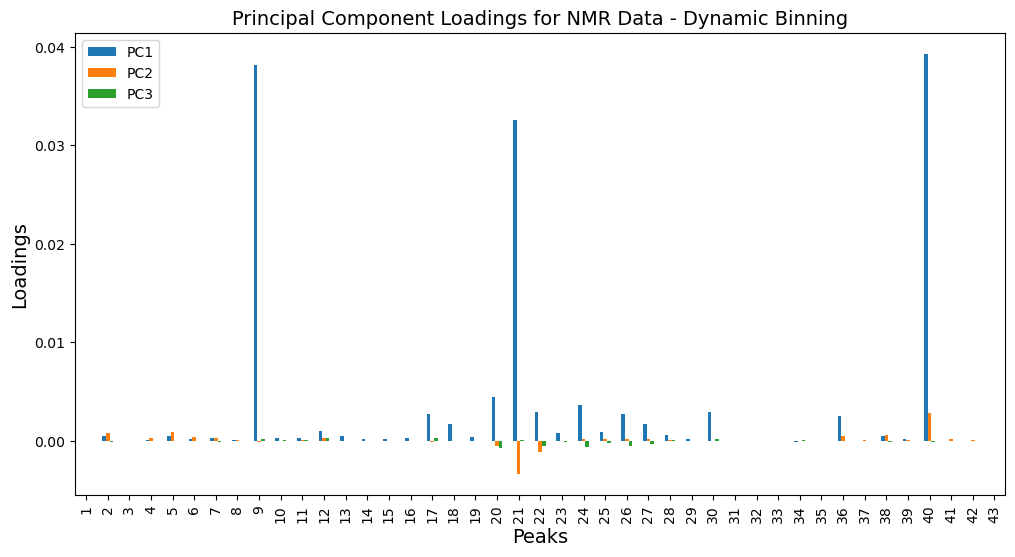

[9.93440253e-01 5.68034729e-03 4.57027626e-04]


In [4]:
pca = PCA(n_components=3)

binned_data_df.columns = [col.replace('Bin', 'Peak') for col in binned_data_df.columns]

binned_data_df.columns = [str(i+1) for i in range(len(binned_data_df.columns))]


principal_components = pca.fit_transform(binned_data_df)
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_matrix = pd.DataFrame(loadings, columns=['PC1', 'PC2', 'PC3'], index=binned_data_df.columns)

fig, ax = plt.subplots(figsize=(12,6))
loading_matrix.plot(kind='bar', ax=ax)
plt.title('Principal Component Loadings for NMR Data - Dynamic Binning', fontsize=14)
plt.ylabel('Loadings', fontsize=14)
plt.xlabel('Peaks', fontsize=14)
plt.show()

# print(principal_df)
# print(loading_matrix)

print(pca.explained_variance_ratio_)

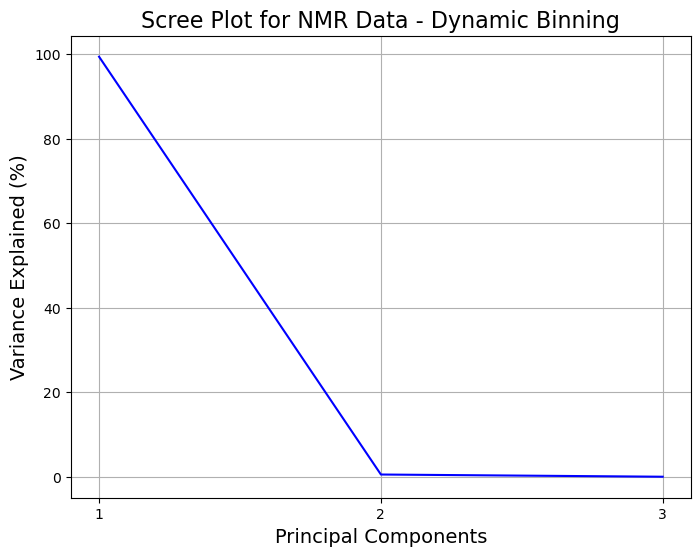

In [5]:
explained_variance = pca.explained_variance_ratio_

fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(range(1, len(explained_variance)+1), explained_variance*100, color='blue')
plt.xlabel('Principal Components', fontsize=14)
plt.ylabel('Variance Explained (%)', fontsize=14)
plt.title('Scree Plot for NMR Data - Dynamic Binning', fontsize=16)
plt.xticks(range(1, len(explained_variance)+1)) 
plt.grid(True)
plt.show()

In [6]:
principal_df.to_csv("/Users/suhasmathey/Library/CloudStorage/OneDrive-UniversityofDelaware-o365/Spring_24/ELEG848 Soft Materials Inn/NMR_Data/PC_NMR.csv")

In [7]:
performance_data = pd.read_csv("/Users/suhasmathey/Library/CloudStorage/OneDrive-UniversityofDelaware-o365/Spring_24/ELEG848 Soft Materials Inn/NMR_Data/tidy_performance_2.0.csv", index_col='Sample')
Y = performance_data['Performance (mean)']

Y.reset_index(drop=True, inplace=True)

poly = PolynomialFeatures(degree=1)
X_poly = poly.fit_transform(principal_df)

lin_reg_poly = LinearRegression()
lin_reg_poly.fit(X_poly, Y)
Y_pred_poly = lin_reg_poly.predict(X_poly)

r_sqaure_poly = r2_score(Y, Y_pred_poly)

Mean_abs_error = mean_absolute_error(Y, Y_pred_poly)
Mean_sqr_error = mean_squared_error(Y, Y_pred_poly)

print("Mean Absolute Error for NMR Data:", Mean_abs_error)
print("Mean Sqaure Error for NMR Data:", Mean_sqr_error)


X_poly_sm = sm.add_constant(X_poly)
ols_model_poly = sm.OLS(Y, X_poly_sm).fit()
ols_summary_poly = ols_model_poly.summary()

print(ols_summary_poly)

Mean Absolute Error for NMR Data: 2.4293097312050524
Mean Sqaure Error for NMR Data: 7.011990853602853
                            OLS Regression Results                            
Dep. Variable:     Performance (mean)   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.005
Date:                Sat, 03 Aug 2024   Prob (F-statistic):              0.439
Time:                        21:35:56   Log-Likelihood:                -28.713
No. Observations:                  12   AIC:                             65.43
Df Residuals:                       8   BIC:                             67.37
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

/Users/suhasmathey/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  k, _ = kurtosistest(a, axis)


In [8]:
tree_reg = DecisionTreeRegressor(max_depth=2)
tree_reg.fit(X_poly, Y)

print(X_poly)

Y_pred_tree = tree_reg.predict(X_poly)
print(Y_pred_tree)

tree_mae = mean_absolute_error(Y, Y_pred_tree)
tree_mse = mean_squared_error(Y, Y_pred_tree)
print("NMR - Decision Tree MAE:", tree_mae)
print("NMR - Decision Tree MSE:", tree_mse)

r2 = r2_score(Y, Y_pred_tree)
print("NMR - R-sqaured for Decision Tree Regressor:", r2)

[[ 1.00000000e+00 -6.62662217e-02 -4.82580986e-03  1.17437170e-04]
 [ 1.00000000e+00  1.75617401e-01  7.79229948e-04 -1.01279457e-03]
 [ 1.00000000e+00  2.00955804e-02  1.59893562e-03 -8.45646289e-04]
 [ 1.00000000e+00 -3.06266972e-02 -1.87447954e-03  7.11572192e-04]
 [ 1.00000000e+00 -2.50529763e-02 -2.44200408e-03 -3.95010030e-04]
 [ 1.00000000e+00  1.48489105e-02 -3.93127194e-03  1.49516911e-03]
 [ 1.00000000e+00 -5.16527707e-02 -3.28736970e-03 -5.84392011e-04]
 [ 1.00000000e+00 -5.98759154e-02  6.45054111e-03 -2.18045278e-03]
 [ 1.00000000e+00 -2.83415850e-02  7.99727366e-03  5.38598611e-04]
 [ 1.00000000e+00  9.41660090e-03  7.69377049e-03  2.30273712e-03]
 [ 1.00000000e+00  1.24908000e-02 -3.62437499e-03 -1.74979254e-03]
 [ 1.00000000e+00  2.93468731e-02 -4.53444073e-03  1.60257402e-03]]
[15.43333333 20.1        20.1        16.82       16.82       15.43333333
 11.5        16.82       16.82       16.82       11.5        15.43333333]
NMR - Decision Tree MAE: 1.4122222222222227
NMR 

In [9]:
print(Y_pred_poly)

[13.71417378 20.01586746 16.98040716 15.02410053 15.1305905  15.43164925
 14.42056457 16.52665691 17.22735293 17.75430003 15.78658844 15.58774843]


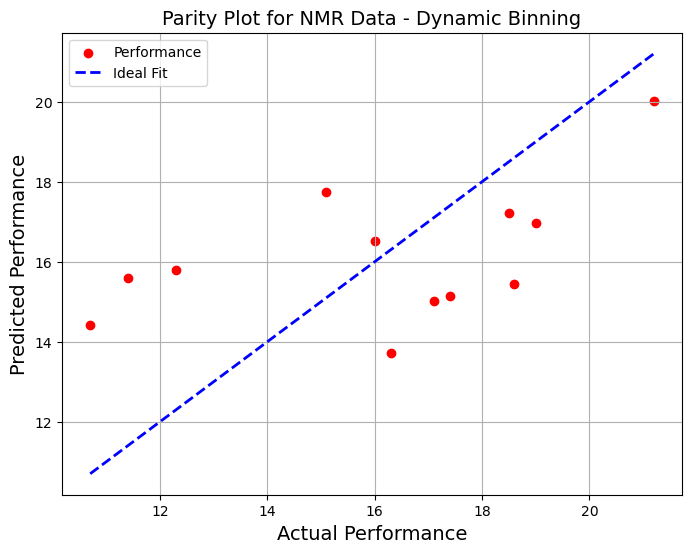

In [10]:
plt.figure(figsize=(8, 6))
plt.scatter(Y, Y_pred_poly, color= 'Red', label='Performance')
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'b--', lw=2, label='Ideal Fit')

plt.xlabel('Actual Performance', fontsize=14)
plt.ylabel('Predicted Performance', fontsize=14)
plt.title('Parity Plot for NMR Data - Dynamic Binning', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()